In [1]:
# A demonstration script for classification with MNIST:
# "Deep Learning with Kernels through RKHM and the Perron-Frobenius Operator".

import numpy.random as nr
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
import numpy as np

d = 32  # We focus on the C*-algebra of d by d matrices and its C*-subalgebras
datanum = 200  # number of training samples
fnum = 40  # number of samples used to construct the represntation space
tdatanum = 1000  # number of test samples
epochs = 100  # number of epochs
c = 0.001  # parameter in the Laplacian kernel
L = 2  # number of the layers
lam1 = 1  # Perron-Frobenius regularlization parameter
lam2 = 0.001  # regularlization parameter for ||f_L||
dim = np.array([7, 4])  # dimension of blocks for each layer
dim1 = np.array(
    [2, 4]
)  # dimension of blocks of the parameter a_j for each layer j

ind = np.arange(0, fnum, 1, dtype=np.int32)

a = []
j = 0
for j in range(L):
    a.append(np.zeros((d, d)))
    for i in range(int(d / dim1[j])):
        a[j][
            dim1[j] * i : dim1[j] * (i + 1), dim1[j] * i : dim1[j] * (i + 1)
        ] = np.ones((dim1[j], dim1[j]))
    a[j] = tf.constant(a[j], tf.float32)


class NN(Model):
    def __init__(self, dim):
        super(NN, self).__init__()
        self.model = models.Sequential()
        self.model.add(layers.Dense(84, activation="sigmoid"))
        self.model.add(layers.Dense(10, activation="softmax"))

    def call(self, x):
        output = self.model(x)

        return output


def tf_kron(a, b):
    a_shape = [a.shape[0], a.shape[1]]
    b_shape = [b.shape[0], b.shape[1]]
    return tf.reshape(
        tf.reshape(a, [a_shape[0], 1, a_shape[1], 1])
        * tf.reshape(b, [1, b_shape[0], 1, b_shape[1]]),
        [a_shape[0] * b_shape[0], a_shape[1] * b_shape[1]],
    )


@tf.function
def opti(label, c1, dense, opt, xtestdata, G, Gtest, Gtmp):
    print("One call")

    with tf.GradientTape(persistent=True) as tape:
        # Ensure dense.trainable_variables are tf.Variables
        trainable_vars = dense.trainable_variables

        ydata = tf.matmul(G, c1[0])
        ytestdata = tf.matmul(Gtest, c1[0])
        Gpre = []
        GGtmp = tf.gather(Gtmp, indices=ind)
        Gpre.append(GGtmp)

        features = ydata[ind[0] * d : (ind[0] + 1) * d, :]
        for i in range(fnum - 1):
            features = tf.concat(
                [features, ydata[ind[i + 1] * d : (ind[i + 1] + 1) * d, :]],
                axis=0,
            )

        for j in range(0, L - 1, 1):
            if j >= 0:
                mdim = dim[j]
            ytmp = tf.matmul(ydata, a[j + 1])
            ytesttmp = tf.matmul(ytestdata, a[j + 1])
            ftmp = tf.matmul(features, a[j + 1])
            tmp1 = tf.reshape(ytmp, [1, datanum, d * d])
            tmp1test = tf.reshape(ytesttmp, [1, tdatanum, d * d])
            tmpf = tf.reshape(ftmp, [1, fnum, d * d])
            for i in range(fnum - 1):
                tmp1 = tf.concat(
                    [tmp1, tf.reshape(ytmp, [1, datanum, d * d])], axis=0
                )
            for i in range(fnum - 1):
                tmp1test = tf.concat(
                    [tmp1test, tf.reshape(ytesttmp, [1, tdatanum, d * d])],
                    axis=0,
                )
            for i in range(tdatanum - 1):
                tmpf = tf.concat(
                    [tmpf, tf.reshape(ftmp, [1, fnum, d * d])], axis=0
                )

            GG = tf.math.exp(
                -c
                * tf.reduce_sum(
                    abs(tf.transpose(tmp1, (1, 0, 2)) - tmpf[0:datanum, :, :]),
                    axis=2,
                )
            )
            GGtmp = tf.gather(GG, indices=ind)
            GG = tf_kron(GG, tf.eye(d)) * tf.matmul(
                ydata, tf.transpose(features, (1, 0))
            )

            Gpre.append(GGtmp)
            GGtest = tf.math.exp(
                -c
                * tf.reduce_sum(
                    abs(tf.transpose(tmp1test, (1, 0, 2)) - tmpf), axis=2
                )
            )
            GGtest = tf_kron(GGtest, tf.eye(d)) * tf.matmul(
                ytestdata, tf.transpose(features, (1, 0))
            )

            ydata = tf.matmul(GG, c1[j + 1])
            ytestdata = tf.matmul(GGtest, c1[j + 1])
            features = ydata[ind[0] * d : (ind[0] + 1) * d, :]
            for i in range(fnum - 1):
                features = tf.concat(
                    [features, ydata[ind[i + 1] * d : (ind[i + 1] + 1) * d, :]],
                    axis=0,
                )

        ydata = dense.call(tf.reshape(ydata, [datanum, d * d]))
        ytestdata = dense.call(tf.reshape(ytestdata, [tdatanum, d * d]))

        reg1 = lam1 * (
            tf.norm(Gpre[L - 1], 2)
            + tf.norm(
                tf.linalg.solve(
                    0.01 * tf.eye(fnum) + Gpre[L - 1], tf.eye(fnum)
                ),
                2,
            )
        )
        reg2 = lam2 * tf.norm(
            tf.matmul(
                tf.matmul(
                    tf.transpose(c1[L - 1], (1, 0)), tf_kron(GGtmp, tf.eye(d))
                ),
                c1[L - 1],
            ),
            2,
        )

        reg = reg1 + reg2

        loss = (
            tf.norm(
                tf.matmul(
                    tf.transpose(ydata - tf.math.real(label), (1, 0)),
                    ydata - tf.math.real(label),
                ),
                2,
            )
            / datanum
        )
        lossreg = loss + reg

        indx = tf.math.argmax(ydata, axis=1)
        indx1 = tf.math.argmax(label, axis=1)
        acc = 1 - tf.math.count_nonzero(indx - indx1) / len(indx)

        indx = tf.math.argmax(ytestdata, axis=1)
        indx1 = tf.math.argmax(labeltest, axis=1)
        acctest = 1 - tf.math.count_nonzero(indx - indx1) / len(indx)

        grad = tape.gradient(lossreg, c1 + trainable_vars)
        opt.apply_gradients(zip(grad, c1 + trainable_vars))

        return acc, acctest, lossreg

    

In [2]:
# Import MNIST data
# mnist = tf.keras.datasets.mnist
# (ydata, label), _ = mnist.load_data()

# Import CIFAR10 data
cifar = tf.keras.datasets.cifar10
(ydata, label), _ = cifar.load_data()
ydata = ydata / np.float64(255.0)

# Change the images to black and white
ydata = np.mean(ydata, axis=3)

print("Shape of the data:", ydata.shape)

xmat = np.zeros((datanum, d, d))
features = np.zeros((fnum, d, d))

xmat = ydata[0:datanum, :, :]

label2 = np.zeros((len(label), 10))
index = [[] for i in range(10)]
for i in range(10):
    index[i] = list(np.where(label == i))[0]
    label2[index[i], i] = np.ones(len(index[i]))

ymat = label2[0:datanum, :]
label = tf.constant(ymat, dtype=tf.float32)

for i in range(fnum):
    features[i, :, :] = xmat[ind[i], :, :]
features = tf.constant(features, dtype=tf.float32)

xdata = tf.constant(xmat, dtype=tf.float32)

xtest = ydata[datanum : datanum + tdatanum, :, :]
labeltest = label2[datanum : datanum + tdatanum, :]

xtestdata = tf.constant(xtest, dtype=tf.float32)
labeltest = tf.constant(labeltest, dtype=tf.float32)

ydata = tf.reshape(xdata, [datanum * d, d])
ytestdata = tf.reshape(xtestdata, [tdatanum * d, d])
features = ydata[ind[0] * d : (ind[0] + 1) * d, :]
for i in range(fnum - 1):
    features = tf.concat(
        [features, ydata[ind[i + 1] * d : (ind[i + 1] + 1) * d, :]], axis=0
    )

ytmp = tf.matmul(ydata, a[0])
ytesttmp = tf.matmul(ytestdata, a[0])
ftmp = tf.matmul(features, a[0])
tmp1 = tf.reshape(ytmp, [1, datanum, d * d])
tmp1test = tf.reshape(ytesttmp, [1, tdatanum, d * d])
tmpf = tf.reshape(ftmp, [1, fnum, d * d])
for i in range(fnum - 1):
    tmp1 = tf.concat([tmp1, tf.reshape(ytmp, [1, datanum, d * d])], axis=0)
for i in range(fnum - 1):
    tmp1test = tf.concat(
        [tmp1test, tf.reshape(ytesttmp, [1, tdatanum, d * d])], axis=0
    )
for i in range(tdatanum - 1):
    tmpf = tf.concat([tmpf, tf.reshape(ftmp, [1, fnum, d * d])], axis=0)

G = tf.math.exp(
    -c
    * tf.reduce_sum(
        abs(tf.transpose(tmp1, (1, 0, 2)) - tmpf[0:datanum, :, :]), axis=2
    )
)
Gtmp = tf.gather(G, indices=ind)

Gtest = tf.math.exp(
    -c
    * tf.reduce_sum(abs(tf.transpose(tmp1test, (1, 0, 2)) - tmpf), axis=2)
)
G = tf_kron(G, tf.eye(d)) * tf.matmul(ydata, tf.transpose(features, (1, 0)))
Gtest = tf_kron(Gtest, tf.eye(d)) * tf.matmul(
    ytestdata, tf.transpose(features, (1, 0))
)

c1 = []
for j in range(L):
    c1.append(np.zeros((d * fnum, d)))

for k in range(L):
    for i in range(fnum):
        for j in range(int(d / dim[k])):
            c1[k][
                i * d + j * dim[k] : i * d + (j + 1) * dim[k],
                j * dim[k] : (j + 1) * dim[k],
            ] = 0.1 * nr.randn(dim[k], dim[k])

for j in range(L):
    c1[j] = tf.Variable(c1[j], dtype=tf.float32)

dense = NN(d)
dense.model(tf.zeros((1, d * d), dtype=tf.float32))
opt = tf.keras.optimizers.Adam(1e-3)
print("Start training with model :", L, "layers")

Shape of the data: (50000, 32, 32)
Start training with model : 2 layers


In [3]:
acccuracy_train = []
acccuracy_test = []
losses = []

for epoch in range(1, epochs + 1, 1):

    acc, acctest, lossreg = opti(
        label, c1, dense, opt, labeltest, G, Gtest, Gtmp
    )

    acccuracy_train.append(acc)
    acccuracy_test.append(acctest)
    losses.append(lossreg)

    # Copy the trainable variables back to the model

    print(
        epoch,
        "Training accuracy:",
        acc.numpy(),
        "Test accuracy:",
        acctest.numpy(),
        flush=True,
    )

    # Plot the results

One call
One call
1 Training accuracy: 0.125 Test accuracy: 0.08899999999999997
2 Training accuracy: 0.10999999999999999 Test accuracy: 0.08899999999999997
3 Training accuracy: 0.14500000000000002 Test accuracy: 0.10699999999999998
4 Training accuracy: 0.16000000000000003 Test accuracy: 0.11599999999999999
5 Training accuracy: 0.15500000000000003 Test accuracy: 0.15600000000000003
6 Training accuracy: 0.18499999999999994 Test accuracy: 0.136
7 Training accuracy: 0.18499999999999994 Test accuracy: 0.11399999999999999
8 Training accuracy: 0.19499999999999995 Test accuracy: 0.133
9 Training accuracy: 0.19499999999999995 Test accuracy: 0.11599999999999999
10 Training accuracy: 0.20999999999999996 Test accuracy: 0.127
11 Training accuracy: 0.235 Test accuracy: 0.14900000000000002
12 Training accuracy: 0.26 Test accuracy: 0.16000000000000003
13 Training accuracy: 0.25 Test accuracy: 0.16999999999999993
14 Training accuracy: 0.24 Test accuracy: 0.16700000000000004
15 Training accuracy: 0.28 T

Text(0.5, 0.98, 'Cifar-10 - n_layers = 2, n_samples = 40')

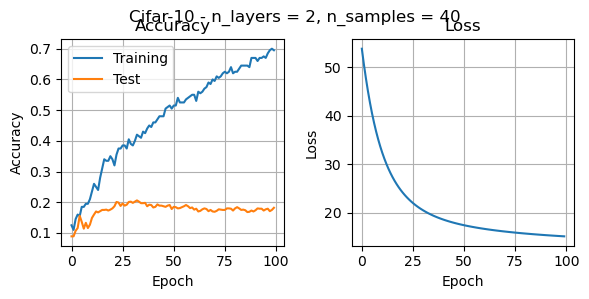

In [ ]:
# Plot the results on subplots
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(1, 2, figsize=(6, 3))
ax1[0].plot(acccuracy_train, label="Training")
ax1[0].plot(acccuracy_test, label="Test")
ax1[0].set_title("Accuracy")
ax1[0].set_xlabel("Epoch")
ax1[0].set_ylabel("Accuracy")
ax1[0].legend()
ax1[0].grid()


ax1[1].plot(losses)
ax1[1].set_title("Loss")
ax1[1].set_xlabel("Epoch")
ax1[1].set_ylabel("Loss")
ax1[1].grid()

# Fig title
plt.suptitle(f"Cifar-10 - n_layers = {L}, n_samples = {fnum}")


